# AutoML with AutoGluon for Tabular Data

In [9]:
# get dataset
! wget https://raw.githubusercontent.com/mgrafals/Uber-Data-Engineering-Project/main/uber_data.csv -P dataset

--2023-06-22 18:29:38--  https://raw.githubusercontent.com/mgrafals/Uber-Data-Engineering-Project/main/uber_data.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15824375 (15M) [text/plain]
Saving to: ‘dataset/uber_data.csv’

uber_data.csv       100%[===================>]  15.09M  6.63MB/s    in 2.3s    

2023-06-22 18:29:43 (6.63 MB/s) - ‘dataset/uber_data.csv’ saved [15824375/15824375]



## Tabular Data Regression

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ray import tune
import seaborn as sns

In [2]:
SEED = 42
MODEL_PATH = 'model'

### Data Preprocessing

In [3]:
data = TabularDataset('dataset/uber_data.csv')
data.head().transpose()

,0,1,2,3,4
VendorID,1,1,2,2,2
tpep_pickup_datetime,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00
tpep_dropoff_datetime,2016-03-01 00:07:55,2016-03-01 00:11:06,2016-03-01 00:31:06,2016-03-01 00:00:00,2016-03-01 00:00:00
passenger_count,1,1,2,3,5
trip_distance,2.5,2.9,19.98,10.78,30.43
pickup_longitude,-73.976746,-73.983482,-73.782021,-73.863419,-73.971741
pickup_latitude,40.765152,40.767925,40.64481,40.769814,40.792183
RatecodeID,1,1,1,1,3
store_and_fwd_flag,N,N,N,N,N
dropoff_longitude,-74.004265,-74.005943,-73.974541,-73.96965,-74.17717


|  | 0 | 1 | 2 | 3 | 4 |
| -- | -- | -- | -- | -- | -- |
| VendorID | 1 | 1 | 2 | 2 | 2 |
| tpep_pickup_datetime | 2016-03-01 00:00:00 | 2016-03-01 00:00:00 | 2016-03-01 00:00:00 | 2016-03-01 00:00:00 | 2016-03-01 00:00:00 |
| tpep_dropoff_datetime | 2016-03-01 00:07:55 | 2016-03-01 00:11:06 | 2016-03-01 00:31:06 | 2016-03-01 00:00:00 | 2016-03-01 00:00:00 |
| passenger_count | 1 | 1 | 2 | 3 | 5 |
| trip_distance | 2.5 | 2.9 | 19.98 | 10.78 | 30.43 |
| pickup_longitude | -73.976746 | -73.983482 | -73.782021 | -73.863419 | -73.971741 |
| pickup_latitude | 40.765152 | 40.767925 | 40.64481 | 40.769814 | 40.792183 |
| RatecodeID | 1 | 1 | 1 | 1 | 3 |
| store_and_fwd_flag | N | N | N | N | N |
| dropoff_longitude | -74.004265 | -74.005943 | -73.974541 | -73.96965 | -74.17717 |
| dropoff_latitude | 40.746128 | 40.733166 | 40.67577 | 40.757767 | 40.695053 |
| payment_type | 1 | 1 | 1 | 1 | 1 |
| fare_amount | 9.0 | 11.0 | 54.5 | 31.5 | 98.0 |
| extra | 0.5 | 0.5 | 0.5 | 0.0 | 0.0 |
| mta_tax | 0.5 | 0.5 | 0.5 | 0.5 | 0.0 |
| tip_amount | 2.05 | 3.05 | 8.0 | 3.78 | 0.0 |
| tolls_amount | 0.0 | 0.0 | 0.0 | 5.54 | 15.5 |
| improvement_surcharge | 0.3 | 0.3 | 0.3 | 0.3 | 0.3 |
| total_amount | 12.35 | 15.35 | 63.8 | 41.62 | 113.8 |

In [4]:
# there are two values that directly scale with the label
# of of passenger fare: fare_amount and total_amount -> drop the latter
data = data.drop('total_amount', axis=1)

In [5]:
data.info()
# RangeIndex: 100000 entries, 0 to 99999
# Data columns (total 18 columns):

<class 'autogluon.core.dataset.TabularDataset'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               100000 non-null  int64  
 1   tpep_pickup_datetime   100000 non-null  object 
 2   tpep_dropoff_datetime  100000 non-null  object 
 3   passenger_count        100000 non-null  int64  
 4   trip_distance          100000 non-null  float64
 5   pickup_longitude       100000 non-null  float64
 6   pickup_latitude        100000 non-null  float64
 7   RatecodeID             100000 non-null  int64  
 8   store_and_fwd_flag     100000 non-null  object 
 9   dropoff_longitude      100000 non-null  float64
 10  dropoff_latitude       100000 non-null  float64
 11  payment_type           100000 non-null  int64  
 12  fare_amount            100000 non-null  float64
 13  extra                  100000 non-null  float64
 14  mta_tax                1000

In [5]:
data_sample = data.sample(frac=0.5 , random_state=SEED)
data_sample.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.883160,1.926360,3.039138,-73.252772,40.355400,1.040780,-73.274211,40.367544,1.337420,13.287511,0.101730,0.496980,1.881304,0.367985,0.299484
std,0.321233,1.586212,3.851644,7.268226,4.002437,0.284462,7.156534,3.940944,0.482423,12.104265,0.202674,0.042906,2.582070,1.521707,0.016749
min,1.000000,0.000000,0.000000,-121.933151,0.000000,1.000000,-121.933327,0.000000,1.000000,-7.000000,-0.500000,-0.500000,-2.700000,0.000000,-0.300000
25%,2.000000,1.000000,1.000000,-73.990921,40.738933,1.000000,-73.990410,40.738776,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000
50%,2.000000,1.000000,1.670000,-73.980164,40.755428,1.000000,-73.978409,40.755249,1.000000,9.500000,0.000000,0.500000,1.360000,0.000000,0.300000
75%,2.000000,2.000000,3.200000,-73.964142,40.769090,1.000000,-73.962097,40.768002,2.000000,15.000000,0.000000,0.500000,2.460000,0.000000,0.300000
max,2.000000,6.000000,160.800000,0.000000,41.204548,6.000000,0.000000,42.666893,4.000000,819.500000,4.500000,0.500000,47.560000,22.040000,0.300000


| | VendorID | passenger_count | trip_distance | pickup_longitude | pickup_latitude | RatecodeID | dropoff_longitude | dropoff_latitude | payment_type | fare_amount | extra | mta_tax | tip_amount | tolls_amount | improvement_surcharge | total_amount |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| count | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 | 50000.000000 |
| mean | 1.883160 | 1.926360 | 3.039138 | -73.252772 | 40.355400 | 1.040780 | -73.274211 | 40.367544 | 1.337420 | 13.287511 | 0.101730 | 0.496980 | 1.881304 | 0.367985 | 0.299484 | 16.434978 |
| std | 0.321233 | 1.586212 | 3.851644 | 7.268226 | 4.002437 | 0.284462 | 7.156534 | 3.940944 | 0.482423 | 12.104265 | 0.202674 | 0.042906 | 2.582070 | 1.521707 | 0.016749 | 14.779261 |
| min | 1.000000 | 0.000000 | 0.000000 | -121.933151 | 0.000000 | 1.000000 | -121.933327 | 0.000000 | 1.000000 | -7.000000 | -0.500000 | -0.500000 | -2.700000 | 0.000000 | -0.300000 | -10.140000 |
| 25% | 2.000000 | 1.000000 | 1.000000 | -73.990921 | 40.738933 | 1.000000 | -73.990410 | 40.738776 | 1.000000 | 6.500000 | 0.000000 | 0.500000 | 0.000000 | 0.000000 | 0.300000 | 8.300000 |
| 50% | 2.000000 | 1.000000 | 1.670000 | -73.980164 | 40.755428 | 1.000000 | -73.978409 | 40.755249 | 1.000000 | 9.500000 | 0.000000 | 0.500000 | 1.360000 | 0.000000 | 0.300000 | 11.800000 |
| 75% | 2.000000 | 2.000000 | 3.200000 | -73.964142 | 40.769090 | 1.000000 | -73.962097 | 40.768002 | 2.000000 | 15.000000 | 0.000000 | 0.500000 | 2.460000 | 0.000000 | 0.300000 | 18.300000 |
| max | 2.000000 | 6.000000 | 160.800000 | 0.000000 | 41.204548 | 6.000000 | 0.000000 | 42.666893 | 4.000000 | 819.500000 | 4.500000 | 0.500000 | 47.560000 | 22.040000 | 0.300000 | 832.800000 |

In [6]:
# 80:20 train test split
train_data = data_sample.sample(n=40000, random_state=SEED)
test_data = data_sample.drop(train_data.index)

### Model Training

In [8]:
predictor = TabularPredictor(label='fare_amount', path=MODEL_PATH)

In [9]:
predictor.fit(train_data)

# AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
# Label info (max, min, mean, stddev): (819.5, -7.0, 13.23572, 11.96267)

# AutoGluon training complete, total runtime = 89.72s ... Best model: "WeightedEnsemble_L2"

Beginning AutoGluon training ...
AutoGluon will save models to "model/"
AutoGluon Version:  0.8.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue May 30 23:14:35 UTC 2023
Disk Space Avail:   63.52 GB / 500.10 GB (12.7%)
Train Data Rows:    40000
Train Data Columns: 17
Label Column: fare_amount
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (819.5, -7.0, 13.23572, 11.96267)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22700.09 MB
	Train Data (Original)  Memory Usage: 1

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -2.766400       0.244695  56.528128                0.000308           0.246437            2       True         12
1         ExtraTreesMSE  -2.967295       0.060220   4.152885                0.060220           4.152885            1       True          7
2               XGBoost  -3.211102       0.005235   0.405672                0.005235           0.405672            1       True          9
3              LightGBM  -3.245028       0.003292   0.341916                0.003292           0.341916            1       True          4
4              CatBoost  -3.246665       0.004185  26.307805                0.004185          26.307805            1       True          6
5       NeuralNetFastAI  -3.300341       0.031887  25.395540                0.031887          25.395540            1       True          8
6         LightGBMLarge  -3

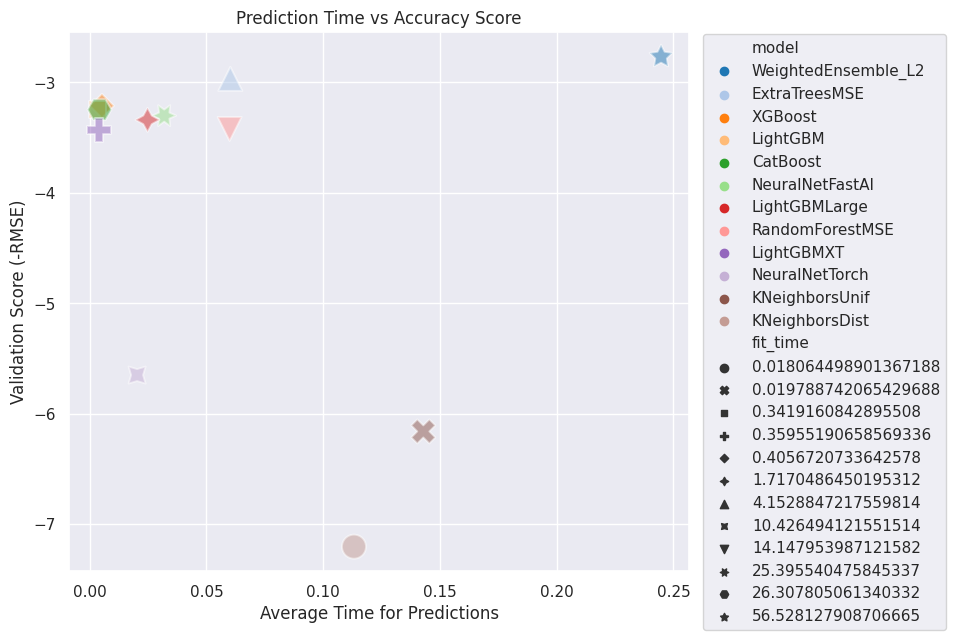

In [10]:
leaderboard=pd.DataFrame(predictor.leaderboard())

plt.figure(figsize=(8, 7))

sns.set(style='darkgrid')

sns.scatterplot(
    x='pred_time_val',
    y='score_val',
    data=leaderboard,
    s=300,
    alpha=0.5,
    hue='model',
    palette='tab20',
    style='fit_time'
)

plt.title('Prediction Time vs Accuracy Score')
plt.xlabel('Average Time for Predictions')
plt.ylabel('Validation Score (-RMSE)')
plt.legend(bbox_to_anchor=(1.01,1.01))

plt.savefig('assets/AutoML_with_AutoGluon_01.webp', bbox_inches='tight')

![AutoML with AutoGluon for Tabular Data](./assets/AutoML_with_AutoGluon_01.webp)

#### Model Loading

In [11]:
# load best model
predictor = TabularPredictor.load("model/")

#### Model Testing Model Testing

In [12]:
X_test = test_data.drop(columns=['fare_amount'] )
y_test = test_data['fare_amount']

In [13]:
y_pred = predictor.predict(X_test)

In [14]:
eval_metrics = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -3.869480242991944
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -3.869480242991944,
    "mean_squared_error": -14.972877350904996,
    "mean_absolute_error": -1.0180752170777319,
    "r2": 0.9064725385773538,
    "pearsonr": 0.9573261149692431,
    "median_absolute_error": -0.5932259559631348
}


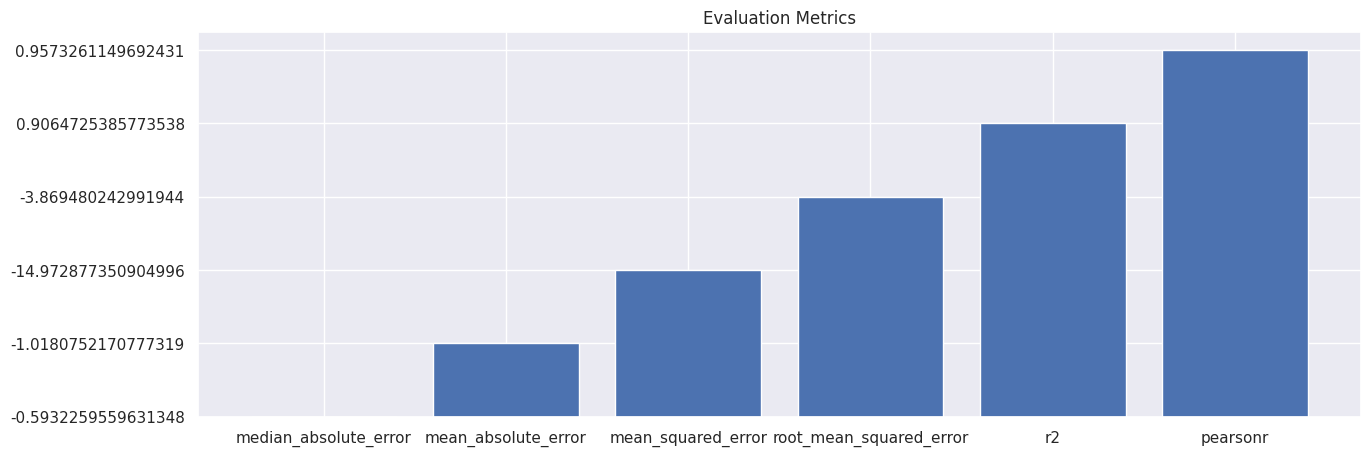

In [15]:
array = np.array(list(eval_metrics.items()))
df = pd.DataFrame(array, columns = ['metric','value']).sort_values(by='value')

plt.figure(figsize=(15,5))
plt.bar(df['metric'], df['value'])
plt.title('Evaluation Metrics')

plt.savefig('assets/AutoML_with_AutoGluon_02.webp', bbox_inches='tight')

![AutoML with AutoGluon for Tabular Data](./assets/AutoML_with_AutoGluon_02.webp)

#### Feature Interpretability

In [43]:
# add test dataset that must include the classifier (fare_amount):
importance_df = predictor.feature_importance(test_data).reset_index()

Computing feature importance via permutation shuffling for 17 features using 5000 rows with 5 shuffle sets...
	71.44s	= Expected runtime (14.29s per shuffle set)
	28.98s	= Actual runtime (Completed 5 of 5 shuffle sets)


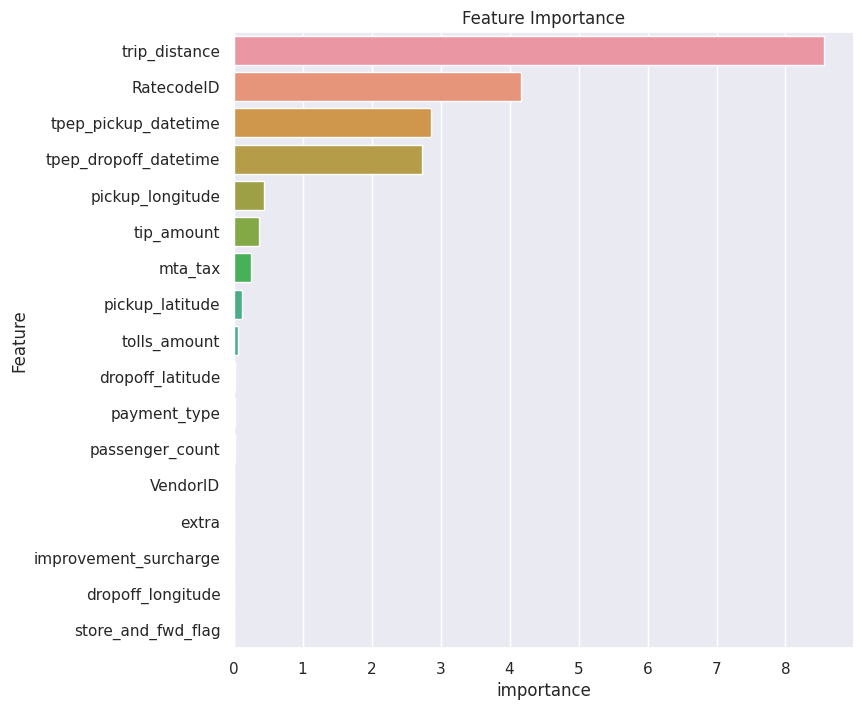

In [44]:
plt.figure(figsize=(8,8))
plt.title('Feature Importance')
sns.set(style='darkgrid')
sns.barplot(
    data=importance_df,
    y='index',
    x='importance',
    orient='horizontal'
).set_ylabel('Feature')

plt.savefig('assets/AutoML_with_AutoGluon_03.webp', bbox_inches='tight')

![AutoML with AutoGluon for Tabular Data](./assets/AutoML_with_AutoGluon_03.webp)

#### Running Predictions

In [47]:
test_drive = {
  "VendorID": 2,
  "tpep_pickup_datetime": "2016-03-01 01:12:39",
  "tpep_dropoff_datetime": "2016-03-01 01:16:48",
  "passenger_count": 5,
  "trip_distance": 1.28,
  "pickup_longitude": -73.97952270507811,
  "pickup_latitude": 40.76089096069336,
  "RatecodeID": 1,
  "store_and_fwd_flag": "N",
  "dropoff_longitude": -73.99040985107422,
  "dropoff_latitude": 40.77185821533203,
  "payment_type": 1,
  "fare_amount": 5.5,
  "extra": 0.5,
  "mta_tax": 0.5,
  "tip_amount": 0.0,
  "tolls_amount": 0.0,
  "improvement_surcharge": 0.3,
  "total_amount": 6.8
}

In [49]:
# load booking into dataset
test_drive_df = TabularDataset.from_dict([test_drive])
test_drive_from_csv_df = TabularDataset('dataset/test_data.csv')

Loaded data from: dataset/test_data.csv | Columns = 19 / 19 | Rows = 1 -> 1


In [50]:
predictor.predict(test_drive_df)
# 0    6.403378
# Name: fare_amount, dtype: float32

0    6.403378
Name: fare_amount, dtype: float32

In [51]:
predictor.predict(test_drive_from_csv_df)
# 0    20.392935
# Name: fare_amount, dtype: float32

0    20.392935
Name: fare_amount, dtype: float32

### Customizations

In [16]:
leaderboard_results = predictor.leaderboard(test_data)

                  model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         ExtraTreesMSE   -3.424482  -2.967295        0.336113       0.060220   4.152885                 0.336113                0.060220           4.152885            1       True          7
1       RandomForestMSE   -3.496445  -3.421289        0.635791       0.059909  14.147954                 0.635791                0.059909          14.147954            1       True          5
2         LightGBMLarge   -3.711858  -3.338691        0.114917       0.024750   1.717049                 0.114917                0.024750           1.717049            1       True         11
3   WeightedEnsemble_L2   -3.869480  -2.766400        0.870554       0.244695  56.528128                 0.003921                0.000308           0.246437            2       True         12
4              CatBoost   -3.875734  -3.

In [18]:
results_df = leaderboard_results[['model', 'score_test', 'score_val', 'pred_time_test', 'fit_time']]
results_df

,model,score_test,score_val,pred_time_test,fit_time
0,ExtraTreesMSE,-3.424482,-2.967295,0.336113,4.152885
1,RandomForestMSE,-3.496445,-3.421289,0.635791,14.147954
2,LightGBMLarge,-3.711858,-3.338691,0.114917,1.717049
3,WeightedEnsemble_L2,-3.869480,-2.766400,0.870554,56.528128
4,CatBoost,-3.875734,-3.246665,0.012133,26.307805
5,XGBoost,-4.003582,-3.211102,0.026592,0.405672
6,LightGBM,-4.547570,-3.245028,0.013185,0.341916
7,NeuralNetFastAI,-4.767402,-3.300341,0.160983,25.395540
8,LightGBMXT,-5.297554,-3.430323,0.016557,0.359552
9,NeuralNetTorch,-7.383115,-5.649417,0.050529,10.426494


|  | model | score_test | score_val | pred_time_test | fit_time |
| -- | -- | -- | -- | -- | -- |
| 0 | ExtraTreesMSE | -3.424482 | -2.967295 | 0.336113 | 4.152885 |
| 1 | RandomForestMSE | -3.496445 | -3.421289 | 0.635791 | 14.147954 |
| 2 | LightGBMLarge | -3.711858 | -3.338691 | 0.114917 | 1.717049 |
| 3 | WeightedEnsemble_L2 | -3.869480 | -2.766400 | 0.870554 | 56.528128 |
| 4 | CatBoost | -3.875734 | -3.246665 | 0.012133 | 26.307805 |
| 5 | XGBoost | -4.003582 | -3.211102 | 0.026592 | 0.405672 |
| 6 | LightGBM | -4.547570 | -3.245028 | 0.013185 | 0.341916 |
| 7 | NeuralNetFastAI | -4.767402 | -3.300341 | 0.160983 | 25.395540 |
| 8 | LightGBMXT | -5.297554 | -3.430323 | 0.016557 | 0.359552 |
| 9 | NeuralNetTorch | -7.383115 | -5.649417 | 0.050529 | 10.426494 |
| 10 | KNeighborsUnif | -7.793495 | -6.159739 | 0.330812 | 0.019789 |
| 11 | KNeighborsDist | -8.238958 | -7.202982 | 0.276046 | 0.018064 |

#### Inference Constraints

The `WeightedEnsemble_L2` model - which is an ensemble of different models used by AutoGluon - has the highest test accuracy but also takes by far the longest to return predictions. The 'non-ensembled' model `ExtraTreesMSE` is not that far off when it comes to accuracy but more than twice as fast with predictions. We can set a restraint how much time is acceptable to remove 'slow' models from the created weighted ensemble model.

In [59]:
fast_predictor = TabularPredictor(label='fare_amount', path='model_fast')
fast_predictor.fit(train_data, time_limit=30, infer_limit=0.000004, infer_limit_batch_size=10000)

# Removing 5/6 base models to satisfy inference constraint (constraint=1.651μs) ...
# 	0.092ms	-> 0.058ms	(KNeighborsUnif)
# 	0.058ms	-> 0.022ms	(KNeighborsDist)
# 	0.022ms	-> 3.321μs	(RandomForestMSE)
# 	3.321μs	-> 1.871μs	(LightGBMXT)
# 	1.871μs	-> 1.177μs	(CatBoost)

Beginning AutoGluon training ... Time limit = 30s
AutoGluon will save models to "model_fast/"
AutoGluon Version:  0.8.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue May 30 23:14:35 UTC 2023
Disk Space Avail:   63.52 GB / 500.10 GB (12.7%)
Train Data Rows:    40000
Train Data Columns: 17
Label Column: fare_amount
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (819.5, -7.0, 13.23572, 11.96267)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    21593.18 MB
	Train Data (Orig

In [63]:
eval_metrics_fast = fast_predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             LightGBM  -3.245028       0.003834   0.588395                0.003834           0.588395            1       True          4
1  WeightedEnsemble_L2  -3.245028       0.004205   0.594806                0.000371           0.006411            2       True          7
2             CatBoost  -3.266919       0.003005   8.212242                0.003005           8.212242            1       True          6
3      RandomForestMSE  -3.421289       0.073429  15.412317                0.073429          15.412317            1       True          5
4           LightGBMXT  -3.430323       0.004597   0.667201                0.004597           0.667201            1       True          3
5       KNeighborsUnif  -6.159739       0.134967   0.365208                0.134967           0.365208        

/home/xiaodie/.local/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


|  | model | score_val | pred_time_val | fit_time | pred_time_val_marginal | fit_time_marginal | stack_level | can_infer | fit_order |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | LightGBM | -3.245028 | 0.003834 | 0.588395 | 0.003834 | 0.588395 | 1 | True | 4 |
| 1 | WeightedEnsemble_L2 | -3.245028 | 0.004205 | 0.594806 | 0.000371 | 0.006411 | 2 | True | 7 |
| 2 | CatBoost | -3.266919 | 0.003005 | 8.212242 | 0.003005 | 8.212242 | 1 | True | 6 |
| 3 | RandomForestMSE | -3.421289 | 0.073429 | 15.412317 | 0.073429 | 15.412317 | 1 | True | 5 |
| 4 | LightGBMXT | -3.430323 | 0.004597 | 0.667201 | 0.004597 | 0.667201 | 1 | True | 3 |
| 5 | KNeighborsUnif | -6.159739 | 0.134967 | 0.365208 | 0.134967 | 0.365208 | 1 | True | 1 |
| 6 | KNeighborsDist | -7.202982 | 0.120473 | 0.394391 | 0.120473 | 0.394391 | 1 | True | 2 |

Number of models trained: 7
Types of models trained:
{'RFModel', 'WeightedEnsembleModel', 'LGBModel', 'KNNModel', 'CatBoostModel'}

In [65]:
eval_metrics = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -2.766400       0.244695  56.528128                0.000308           0.246437            2       True         12
1         ExtraTreesMSE  -2.967295       0.060220   4.152885                0.060220           4.152885            1       True          7
2               XGBoost  -3.211102       0.005235   0.405672                0.005235           0.405672            1       True          9
3              LightGBM  -3.245028       0.003292   0.341916                0.003292           0.341916            1       True          4
4              CatBoost  -3.246665       0.004185  26.307805                0.004185          26.307805            1       True          6
5       NeuralNetFastAI  -3.300341       0.031887  25.395540                0.031887          25.395540 

/home/xiaodie/.local/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


|  | model | score_val | pred_time_val | fit_time | pred_time_val_marginal | fit_time_marginal | stack_level | can_infer | fit_order |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | WeightedEnsemble_L2 | -2.766400 | 0.244695 | 56.528128 | 0.000308 | 0.246437 | 2 | True | 12 |
| 1 | ExtraTreesMSE | -2.967295 | 0.060220 | 4.152885 | 0.060220 | 4.152885 | 1 | True | 7 |
| 2 | XGBoost | -3.211102 | 0.005235 | 0.405672 | 0.005235 | 0.405672 | 1 | True | 9 |
| 3 | LightGBM | -3.245028 | 0.003292 | 0.341916 | 0.003292 | 0.341916 | 1 | True | 4 |
| 4 | CatBoost | -3.246665 | 0.004185 | 26.307805 | 0.004185 | 26.307805 | 1 | True | 6 |
| 5 | NeuralNetFastAI | -3.300341 | 0.031887 | 25.395540 | 0.031887 | 25.395540 | 1 | True | 8 |
| 6 | LightGBMLarge | -3.338691 | 0.024750 | 1.717049 | 0.024750 | 1.717049 | 1 | True | 11 |
| 7 | RandomForestMSE | -3.421289 | 0.059909 | 14.147954 | 0.059909 | 14.147954 | 1 | True | 5 |
| 8 | LightGBMXT | -3.430323 | 0.003857 | 0.359552 | 0.003857 | 0.359552 | 1 | True | 3 |
| 9 | NeuralNetTorch | -5.649417 | 0.020283 | 10.426494 | 0.020283 | 10.426494 | 1 | True | 10 |
| 10 | KNeighborsUnif | -6.159739 | 0.142860 | 0.019789 | 0.142860 | 0.019789 | 1 | True | 1 |
| 11 | KNeighborsDist | -7.202982 | 0.113172 | 0.018064 | 0.113172 | 0.018064 | 1 | True | 2 |

Number of models trained: 12
Types of models trained:
{'RFModel', 'XGBoostModel', 'WeightedEnsembleModel', 'XTModel', 'NNFastAiTabularModel', 'LGBModel', 'KNNModel', 'CatBoostModel', 'TabularNeuralNetTorchModel'}

Result: _Much faster but less accurate_

* __WeightedEnsemble\_L2__:
  * score_val: `-2.766400` -> `-3.245028`
  * pred_time_val: `0.244695s` -> `0.004205s`
  * fit_time: `56.528128s` -> `0.594806s`

#### Hyperparameter Tuning

In [78]:
hyperparameters_NN_Torch = {"num_epochs": 1, "learning_rate": 0.5}
hyperparameters_XGB = {} # use XGBoost with default values
hyperparameters = {"NN_TORCH": hyperparameters_NN_Torch, "XGB": hyperparameters_XGB}

In [79]:
tuned_predictor = TabularPredictor(label='fare_amount', path='model_tuned')
tuned_predictor.fit(
        train_data=train_data,
        hyperparameters=hyperparameters
    )

Beginning AutoGluon training ...
AutoGluon will save models to "model_tuned/"
AutoGluon Version:  0.8.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue May 30 23:14:35 UTC 2023
Disk Space Avail:   63.51 GB / 500.10 GB (12.7%)
Train Data Rows:    40000
Train Data Columns: 17
Label Column: fare_amount
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (819.5, -7.0, 13.23572, 11.96267)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    20526.99 MB
	Train Data (Original)  Memory Us

In [80]:
tuned_predictor.fit_summary()
# AutoGluon only trained the two configured model for one epoch 

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              XGBoost  -3.211102       0.003993  0.363999                0.003993           0.363999            1       True          1
1  WeightedEnsemble_L2  -3.211102       0.004304  0.434471                0.000311           0.070472            2       True          3
2       NeuralNetTorch -23.769987       0.019870  0.935391                0.019870           0.935391            1       True          2
Number of models trained: 3
Types of models trained:
{'XGBoostModel', 'TabularNeuralNetTorchModel', 'WeightedEnsembleModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', [])                : 10 | ['trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', ...]
('in

/home/xiaodie/.local/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'XGBoost': -3.211102335193632,
  'NeuralNetTorch': -23.769987410919043,
  'WeightedEnsemble_L2': -3.211102335193632},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'XGBoost': 'model_tuned/models/XGBoost/',
  'NeuralNetTorch': 'model_tuned/models/NeuralNetTorch/',
  'WeightedEnsemble_L2': 'model_tuned/models/WeightedEnsemble_L2/'},
 'model_fit_times': {'XGBoost': 0.3639991283416748,
  'NeuralNetTorch': 0.9353909492492676,
  'WeightedEnsemble_L2': 0.07047200202941895},
 'model_pred_times': {'XGBoost': 0.003993034362792969,
  'NeuralNetTorch': 0.019869565963745117,
  'WeightedEnsemble_L2': 0.00031065940856933594},
 'num_bag_folds': 0,
 'max_stack_level': 2,
 'model_hyperparams': {'XGBoost': {'n_estimators': 10000,
   'learning_rate': 0.1,
   'n_jobs': -1,
   'proc.max_category_levels': 100,
   'objective': 'reg:squ

|  | model | score_val | pred_time_val | fit_time | pred_time_val_marginal | fit_time_marginal | stack_level | can_infer | fit_order |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | XGBoost | -3.211102 | 0.003993 | 0.363999 | 0.003993 | 0.363999 | 1 | True | 1 |
| 1 | WeightedEnsemble_L2 | -3.211102 | 0.004304 | 0.434471 | 0.000311 | 0.070472 | 2 | True | 3 |
| 2 | NeuralNetTorch | -23.769987 | 0.019870 | 0.935391 | 0.019870 | 0.935391 | 1 | True | 2 |

#### AutoGluon Presets

> Available Presets: [`best_quality`, `high_quality`, `good_quality`, `medium_quality`, `optimize_for_deployment`, `interpretable`, `ignore_text`]

In [81]:
presets = ['medium_quality'] # accept lower accuracy for speed

In [83]:
preset_predictor = TabularPredictor(label='fare_amount', path='preset_model')
preset_predictor.fit(
        train_data=train_data,
        presets=presets,
        included_model_types=['GBM', 'FASTAI', 'NN_TORCH'], # only use those models
        # excluded_model_types=['KNN', 'NN', 'XT', 'RF', 'FASTAI'] # use all but those models
    )

Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "preset_model/"
AutoGluon Version:  0.8.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue May 30 23:14:35 UTC 2023
Disk Space Avail:   63.52 GB / 500.10 GB (12.7%)
Train Data Rows:    40000
Train Data Columns: 17
Label Column: fare_amount
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (819.5, -7.0, 13.23572, 11.96267)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    20816.

In [84]:
preset_predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2  -3.054243       0.083915  42.906133                0.000301           0.133571            2       True          6
1             LightGBM  -3.245028       0.003262   0.507183                0.003262           0.507183            1       True          2
2      NeuralNetFastAI  -3.300341       0.027946  26.112154                0.027946          26.112154            1       True          3
3        LightGBMLarge  -3.338691       0.026010   1.953629                0.026010           1.953629            1       True          5
4           LightGBMXT  -3.430323       0.004276   0.458992                0.004276           0.458992            1       True          1
5       NeuralNetTorch  -5.649417       0.022120  13.740605                0.022120          13.740605        

/home/xiaodie/.local/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT': -3.430323408069052,
  'LightGBM': -3.2450278853569237,
  'NeuralNetFastAI': -3.3003409207633725,
  'NeuralNetTorch': -5.649417242124493,
  'LightGBMLarge': -3.3386909966101883,
  'WeightedEnsemble_L2': -3.054243292051689},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMXT': 'preset_model/models/LightGBMXT/',
  'LightGBM': 'preset_model/models/LightGBM/',
  'NeuralNetFastAI': 'preset_model/models/NeuralNetFastAI/',
  'NeuralNetTorch': 'preset_model/models/NeuralNetTorch/',
  'LightGBMLarge': 'preset_model/models/LightGBMLarge/',
  'WeightedEnsemble_L2': 'preset_model/models/WeightedEnsemble_L2/'},
 'model_fit_times': {'LightGBMXT': 0.45899176597595215,
  'LightGBM': 0.5071825981140137,
  'Neu

|  | model | score_val | pred_time_val | fit_time | pred_time_val_marginal | fit_time_marginal | stack_level | can_infer | fit_order |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | WeightedEnsemble_L2 | -3.054243 | 0.083915 | 42.906133 | 0.000301 | 0.133571 | 2 | True | 6 |
| 1 | LightGBM | -3.245028 | 0.003262 | 0.507183 | 0.003262 | 0.507183 | 1 | True | 2 |
| 2 | NeuralNetFastAI | -3.300341 | 0.027946 | 26.112154 | 0.027946 | 26.112154 | 1 | True | 3 |
| 3 | LightGBMLarge | -3.338691 | 0.026010 | 1.953629 | 0.026010 | 1.953629 | 1 | True | 5 |
| 4 | LightGBMXT | -3.430323 | 0.004276 | 0.458992 | 0.004276 | 0.458992 | 1 | True | 1 |
| 5 | NeuralNetTorch | -5.649417 | 0.022120 | 13.740605 | 0.022120 | 13.740605 | 1 | True | 4 |

## Model Deployment

In [7]:
predictor = TabularPredictor.load("model/")

In [8]:
# retain model on train + validation dataset
predictor.refit_full()

{'KNeighborsUnif': 'KNeighborsUnif_FULL',
 'KNeighborsDist': 'KNeighborsDist_FULL',
 'LightGBMXT': 'LightGBMXT_FULL',
 'LightGBM': 'LightGBM_FULL',
 'RandomForestMSE': 'RandomForestMSE_FULL',
 'CatBoost': 'CatBoost_FULL',
 'ExtraTreesMSE': 'ExtraTreesMSE_FULL',
 'NeuralNetFastAI': 'NeuralNetFastAI_FULL',
 'XGBoost': 'XGBoost_FULL',
 'NeuralNetTorch': 'NeuralNetTorch_FULL',
 'LightGBMLarge': 'LightGBMLarge_FULL',
 'WeightedEnsemble_L2': 'WeightedEnsemble_L2_FULL'}

In [10]:
# strip all models not part of the `WeightedEnsemble_L2_FULL`
predictor.clone_for_deployment('production_model')
# Clone: Keeping minimum set of models required to predict with best model 'WeightedEnsemble_L2_FULL'...
# To load the cloned predictor: predictor_clone = TabularPredictor.load(path="production_model")

Cloned TabularPredictor located in 'model/' to 'production_model'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="production_model")
Clone: Keeping minimum set of models required to predict with best model 'WeightedEnsemble_L2_FULL'...
Deleting model KNeighborsUnif. All files under production_model/models/KNeighborsUnif/ will be removed.
Deleting model KNeighborsDist. All files under production_model/models/KNeighborsDist/ will be removed.
Deleting model LightGBMXT. All files under production_model/models/LightGBMXT/ will be removed.
Deleting model LightGBM. All files under production_model/models/LightGBM/ will be removed.
Deleting model RandomForestMSE. All files under production_model/models/RandomForestMSE/ will be removed.
Deleting model CatBoost. All files under production_model/models/CatBoost/ will be removed.
Deleting model ExtraTreesMSE. All files under production_model/models/ExtraTreesMSE/ will be removed.
Deleting model NeuralNetFastAI. All fi

'production_model/'

In [11]:
predictor_clone = TabularPredictor.load(path="production_model")

In [13]:
test_data = TabularDataset('dataset/test_data.csv')
predictor_clone.predict(test_data)

# 0    20.425285
# Name: fare_amount, dtype: float32

0    20.425285
Name: fare_amount, dtype: float32